# Install

In [1]:
%pip install tensorflow tf2onnx matplotlib numpy opencv-python scipy

  Using cached protobuf-6.33.0-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
INFO: pip is looking at multiple versions of tf2onnx to determine which version is compatible with other requirements. This could take a while.
  Using cached tf2onnx-1.16.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.15.1-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.15.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.14.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.13.0-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.12.1-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.12.0-py3-none-any.whl.metadata (1.2 kB)
INFO: pip is still looking at multiple versions of tf2onnx to determine which version is compatible with other requirements. This could take a while.
  Using cached tf2onnx-1.11.1-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.10.1-py3-none-any.whl.metadata (1.2 kB)
  Using cached tf2onnx-1.9.3-py3

In [2]:
%pip install --upgrade --force-reinstall tensorflow tf2onnx matplotlib numpy opencv-python scipy mediapipe pandas tqdm scikit-learn 


  Using cached tensorflow-2.20.0-cp312-cp312-macosx_12_0_arm64.whl.metadata (4.5 kB)
  Using cached tf2onnx-1.16.1-py3-none-any.whl.metadata (1.3 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached numpy-2.3.4-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
  Using cached scipy-1.16.2-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached mediapipe-0.10.21-cp312-cp312-macosx_11_0_universal2.whl.metadata (9.9 kB)
  Using cached pandas-2.3.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached scikit_learn-1.7.2-cp312-cp312-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 b

In [3]:
import sys
import subprocess

subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])

0

In [ ]:
%pip install --upgrade --force-reinstall tf2onnx

# import and constant

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import string
import os
import shutil
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import joblib

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
dataset_dir = './dataset'
model_name = 'sign_classifier'

# Dataset

In [6]:
!curl -L -o ./alfabet-bisindo.zip\
  https://www.kaggle.com/api/v1/datasets/download/achmadnoer/alfabet-bisindo

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0  114M    0 83232    0     0  54378      0  0:36:51  0:00:01  0:36:50 54378
  8  114M    8 10.0M    0     0  4148k      0  0:00:28  0:00:02  0:00:26 10.5M
 18  114M   18 21.2M    0     0  6273k      0  0:00:18  0:00:03  0:00:15 10.9M
 28  114M   28 32.5M    0     0  7453k      0  0:00:15  0:00:04  0:00:11 11.0M
 38  114M   38 43.8M    0     0  8198k      0  0:00:14  0:00:05  0:00:09 11.0M
 48  114M   48 55.1M    0     0  8716k      0  0:00:13  0:00:06  0:00:07 11.1M
 56  114M   56 65.1M    0     0  8920k      0  0:00:13  0:00:07  0:00:06 11.0M
 66  114M   66 76.4M    0     0  9230k      0  0:0

In [18]:
import zipfile
import os
import platform

zip_path = "./alfabet-bisindo.zip"
extract_dir = "./"

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {zip_path}")

print(f"📦 Ekstraksi dataset dari {zip_path} ...")
if platform.system() in ["Windows", "Darwin", "Linux"]:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset berhasil diekstrak ke {extract_dir}")
else:
    print(f"⚠️ OS {platform.system()} belum dikenali, pastikan unzip dilakukan manual.")


📦 Ekstraksi dataset dari ./alfabet-bisindo.zip ...
✅ Dataset berhasil diekstrak ke ./


In [19]:
import os
import shutil

src_dir = "Citra BISINDO"
dst_dir = "./dataset"

if not os.path.exists(src_dir):
    raise FileNotFoundError(f"❌ Folder sumber tidak ditemukan: {src_dir}")

os.makedirs(dst_dir, exist_ok=True)

print(f"📂 Memindahkan '{src_dir}' ke '{dst_dir}' ...")
shutil.move(src_dir, dst_dir)
print(f"✅ Berhasil dipindahkan ke {dst_dir}")


📂 Memindahkan 'Citra BISINDO' ke './dataset' ...
✅ Berhasil dipindahkan ke ./dataset


In [1]:
!curl -L -o ./indonesian-sign-language-bisindo.zip\
  https://www.kaggle.com/api/v1/datasets/download/agungmrf/indonesian-sign-language-bisindo

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 1396M    0  110k    0     0  70686      0  5:45:23  0:00:01  5:45:22  111k
  0 1396M    0 2528k    0     0   976k      0  0:24:25  0:00:02  0:24:23 1277k
  0 1396M    0 7005k    0     0  1950k      0  0:12:13  0:00:03  0:12:10 2350k
  0 1396M    0 11.4M    0     0  2551k      0  0:09:20  0:00:04  0:09:16 2942k
  1 1396M    1 16.0M    0     0  2945k      0  0:08:05  0:00:05  0:08:00 3306k
  1 1396M    1 20.4M    0     0  3179k      0  0:07:29  0:00:06  0:07:23 4178k
  1 1396M    1 23.4M    0     0  3167k      0  0:07:31  0:00:07  0:07:24 4303k
  1 1396M    1 27.1M    0     0  3238k      0  0:0

In [2]:
def merge_dataset(src_folder):
    """
    Move files from src_folder into dataset, preserving subfolder (label) structure.
    Example: src_folder/cat -> dataset/cat
             src_folder/dog -> dataset/dog
    """
    # Ensure destination exists
    os.makedirs(dataset_dir, exist_ok=True)

    # Iterate over all label folders in the source
    for label in os.listdir(src_folder):
        label_path_src = os.path.join(src_folder, label)
        label_path_dest = os.path.join(dataset_dir, label)

        # Skip if not a folder
        if not os.path.isdir(label_path_src):
            continue

        # Create label folder in destination if needed
        os.makedirs(label_path_dest, exist_ok=True)

        # Move all files from src → dest
        for filename in os.listdir(label_path_src):
            src = os.path.join(label_path_src, filename)
            dst = os.path.join(label_path_dest, filename)

            # Avoid overwriting files with same name
            if os.path.exists(dst):
                base, ext = os.path.splitext(filename)
                dst = os.path.join(label_path_dest, f"{base}_2{ext}")

            shutil.move(src, dst)

    print(f"✅ Merged '{src_folder}' into '{dataset_dir}' successfully!")

In [ ]:
import zipfile
import os
import platform

zip_path = "./indonesian-sign-language-bisindo.zip"
extract_dir = "./"

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {zip_path}")

print(f"📦 Ekstraksi dataset dari {zip_path} ...")
if platform.system() in ["Windows", "Darwin", "Linux"]:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset berhasil diekstrak ke {extract_dir}")
else:
    print(f"⚠️ OS {platform.system()} belum dikenali, pastikan unzip dilakukan manual.")


📦 Ekstraksi dataset dari ./indonesian-sign-language-bisindo.zip ...
✅ Dataset berhasil diekstrak ke ./


In [8]:
merge_dataset('./bisindo/images/train')

✅ Merged './bisindo/images/train' into './dataset' successfully!


In [9]:
merge_dataset('./bisindo/images/val')

✅ Merged './bisindo/images/val' into './dataset' successfully!


In [10]:
import shutil
import os

folder_path = "./bisindo"

if os.path.exists(folder_path):
    print(f"🗑️ Menghapus folder: {folder_path}")
    shutil.rmtree(folder_path)
    print("✅ Folder berhasil dihapus.")
else:
    print("⚠️ Folder tidak ditemukan, tidak ada yang dihapus.")

🗑️ Menghapus folder: ./bisindo
✅ Folder berhasil dihapus.


In [11]:
!curl -L -o ./bisindo-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/yunitayupratiwi/bisindo-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 24.1M    0   527    0     0    426      0 16:30:15  0:00:01 16:30:14   426
  2 24.1M    2  501k    0     0   239k      0  0:01:43  0:00:02  0:01:41  585k
  2 24.1M    2  723k    0     0   213k      0  0:01:55  0:00:03  0:01:52  334k
  2 24.1M    2  723k    0     0   164k      0  0:02:30  0:00:04  0:02:26  228k
  2 24.1M    2  723k    0     0   134k      0  0:03:04  0:00:05  0:02:59  173k
  2 24.1M    2  723k    0     0   113k      0  0:03:38  0:00:06  0:03:32  140k
  2 24.1M    2  723k    0     0    97k      0  0:04:12  0:00:07  0:04:05 42896
  2 24.1M    2  723k    0     0  88168      0  0:0

In [12]:
import zipfile
import os
import platform

zip_path = "./bisindo-dataset.zip"
extract_dir = "./"

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {zip_path}")

print(f"📦 Ekstraksi dataset dari {zip_path} ...")
if platform.system() in ["Windows", "Darwin", "Linux"]:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset berhasil diekstrak ke {extract_dir}")
else:
    print(f"⚠️ OS {platform.system()} belum dikenali, pastikan unzip dilakukan manual.")


📦 Ekstraksi dataset dari ./bisindo-dataset.zip ...
✅ Dataset berhasil diekstrak ke ./


In [13]:
def construct_dataset(src_folder):
    """
    Move files from src_folder into dataset, based on the first letter of the filename.
    Example: src_folder/A.66ae97e2-c1e4-11eb-83d3-0008ca6b6d30.jpg -> dataset/A
             src_folder/B.002d8fdf-c1e3-11eb-952a-0008ca6b6d30.jpg -> dataset/B
    """
    # Ensure destination exists
    os.makedirs(dataset_dir, exist_ok=True)

    # Iterate over all file folders in the source
    for filename in os.listdir(src_folder):
        src_file = os.path.join(src_folder, filename)

        # Skip if a folder
        if os.path.isdir(src_file):
            continue
        
        # Skip if not a jpg
        if not src_file.lower().endswith('.jpg'):
            continue
        
        label = filename[0].upper()  # First character as label
        dest = os.path.join(dataset_dir, label)
        # Create label folder in destination if needed
        os.makedirs(dest, exist_ok=True)

        dst_file = os.path.join(dest, filename)

        # Avoid overwriting files with same name
        if os.path.exists(dst_file):
            base, ext = os.path.splitext(filename)
            dst_file = os.path.join(dest, f"{base}_3{ext}")

        shutil.move(src_file, dst_file)

    print(f"successfully!")

In [14]:
construct_dataset("./BISINDO - Dataset/test")

successfully!


In [15]:
construct_dataset("./BISINDO - Dataset/train")

successfully!


In [16]:
import shutil
import os

folder_path = "./BISINDO - Dataset"

if os.path.exists(folder_path):
    print(f"🗑️ Menghapus folder: {folder_path}")
    shutil.rmtree(folder_path)
    print("✅ Folder berhasil dihapus.")
else:
    print("⚠️ Folder tidak ditemukan, tidak ada yang dihapus.")

🗑️ Menghapus folder: ./BISINDO - Dataset
✅ Folder berhasil dihapus.


In [4]:
!curl -L -o ./sign-language-bisindo.zip\
  https://www.kaggle.com/api/v1/datasets/download/bonarsitorus/sign-language-bisindo

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  238M  100  238M    0     0  2646k      0  0:01:32  0:01:32 --:--:-- 2901k  2370k      0  0:01:43  0:00:05  0:01:38 3158k   0  0:01:35  0:00:47  0:00:48 2584k590k      0  0:01:34  0:00:54  0:00:40 2818k   0  0:01:34  0:01:02  0:00:32 2759k1:33  0:01:15  0:00:18 2674k0  2626k      0  0:01:33  0:01:16  0:00:17 2800k


In [6]:
import zipfile
import os
import platform

zip_path = "./sign-language-bisindo.zip"
extract_dir = "./"

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {zip_path}")

print(f"📦 Ekstraksi dataset dari {zip_path} ...")
if platform.system() in ["Windows", "Darwin", "Linux"]:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset berhasil diekstrak ke {extract_dir}")
else:
    print(f"⚠️ OS {platform.system()} belum dikenali, pastikan unzip dilakukan manual.")


📦 Ekstraksi dataset dari ./sign-language-bisindo.zip ...
✅ Dataset berhasil diekstrak ke ./


In [7]:
def merge_dataset_4(src_folder):
    """
    Move files from src_folder into dataset, preserving subfolder (label) structure,
    except folders with '_npy' in their name.
    """
    # Pastikan folder tujuan ada
    os.makedirs(dataset_dir, exist_ok=True)

    # Iterasi semua folder di src_folder
    for label in os.listdir(src_folder):
        # Lewati folder yang mengandung '_npy'
        if "_npy" in label:
            continue

        label_path_src = os.path.join(src_folder, label)
        label_path_dest = os.path.join(dataset_dir, label)

        # Pastikan ini folder
        if not os.path.isdir(label_path_src):
            continue

        # Buat folder di tujuan jika belum ada
        os.makedirs(label_path_dest, exist_ok=True)

        # Pindahkan semua file
        for filename in os.listdir(label_path_src):
            src = os.path.join(label_path_src, filename)
            dst = os.path.join(label_path_dest, filename)

            # Hindari overwrite
            if os.path.exists(dst):
                base, ext = os.path.splitext(filename)
                dst = os.path.join(label_path_dest, f"{base}_4{ext}")

            shutil.move(src, dst)

    print(f"✅ Merged '{src_folder}' into '{dataset_dir}' successfully!")

In [8]:
merge_dataset_4('./data_tambahan')

✅ Merged './data_tambahan' into './dataset' successfully!


In [9]:
import shutil
import os

folder_path = "./data_tambahan"

if os.path.exists(folder_path):
    print(f"🗑️ Menghapus folder: {folder_path}")
    shutil.rmtree(folder_path)
    print("✅ Folder berhasil dihapus.")
else:
    print("⚠️ Folder tidak ditemukan, tidak ada yang dihapus.")

🗑️ Menghapus folder: ./data_tambahan
✅ Folder berhasil dihapus.


In [10]:
!curl -L -o ./indonesian-hand-sign-language-bisindo-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/kelsha/indonesian-hand-sign-language-bisindo-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1944M  100 1944M    0     0  2602k      0  0:12:45  0:12:45 --:--:-- 2673k   0     0  2393k      0  0:13:52  0:00:13  0:13:39 2692kk      0  0:12:47  0:00:39  0:12:08 2700k:00  0:11:38 2686k   0  0:12:32  0:01:23  0:11:09 2677k655k      0  0:12:29  0:01:38  0:10:51 2709k    0     0  2657k      0  0:12:29  0:01:42  0:10:47 2615k 2660k      0  0:12:28  0:02:05  0:10:23 2516k31  0:02:29  0:10:02 2710k 0  2644k      0  0:12:32  0:03:03  0:09:29 2612k11  0:09:20 2628k      0  0:12:32  0:03:25  0:09:07 2644k0:12:32  0:03:30  0:09:02 2652k 2642k      0  0:12:33  0:03:44  0:08:49 2555k7k      0  0:12:38  0:04:26  0:08:12 2576k      0  0:12:37  0:04:28  0:08:09 2770k:37  0:08:00 2650k      0  0:12:37  0:04:41  0:07:56 2721k    0  0:12:37  0:04:45  0:07:52 26

In [11]:
import zipfile
import os
import platform

zip_path = "./indonesian-hand-sign-language-bisindo-dataset.zip"
extract_dir = "./"

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {zip_path}")

print(f"📦 Ekstraksi dataset dari {zip_path} ...")
if platform.system() in ["Windows", "Darwin", "Linux"]:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset berhasil diekstrak ke {extract_dir}")
else:
    print(f"⚠️ OS {platform.system()} belum dikenali, pastikan unzip dilakukan manual.")


📦 Ekstraksi dataset dari ./indonesian-hand-sign-language-bisindo-dataset.zip ...
✅ Dataset berhasil diekstrak ke ./


In [12]:
def merge_dataset_5(src_folder):
    """
    Move files from src_folder into dataset, preserving subfolder (label) structure.
    """
    # Pastikan folder tujuan ada
    os.makedirs(dataset_dir, exist_ok=True)

    # Iterasi semua folder di src_folder
    for label in os.listdir(src_folder):

        label_path_src = os.path.join(src_folder, label)
        label_path_dest = os.path.join(dataset_dir, label)

        # Pastikan ini folder
        if not os.path.isdir(label_path_src):
            continue

        # Buat folder di tujuan jika belum ada
        os.makedirs(label_path_dest, exist_ok=True)

        # Pindahkan semua file
        for filename in os.listdir(label_path_src):
            src = os.path.join(label_path_src, filename)
            dst = os.path.join(label_path_dest, filename)

            # Hindari overwrite
            if os.path.exists(dst):
                base, ext = os.path.splitext(filename)
                dst = os.path.join(label_path_dest, f"{base}_5{ext}")

            shutil.move(src, dst)

    print(f"✅ Merged '{src_folder}' into '{dataset_dir}' successfully!")

In [19]:
merge_dataset_5('./dataset_bisindo/train/images')

✅ Merged './dataset_bisindo/train/images' into './dataset' successfully!


In [21]:
merge_dataset_5('./dataset_bisindo/val/images')

✅ Merged './dataset_bisindo/val/images' into './dataset' successfully!


In [22]:
import shutil
import os

folder_path = "./dataset_bisindo"

if os.path.exists(folder_path):
    print(f"🗑️ Menghapus folder: {folder_path}")
    shutil.rmtree(folder_path)
    print("✅ Folder berhasil dihapus.")
else:
    print("⚠️ Folder tidak ditemukan, tidak ada yang dihapus.")

🗑️ Menghapus folder: ./dataset_bisindo
✅ Folder berhasil dihapus.


In [23]:
!curl -L -o ./bisindo-final.zip\
  https://www.kaggle.com/api/v1/datasets/download/skripsiairlangga/bisindo-final

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2198M  100 2198M    0     0  2601k      0  0:14:25  0:14:25 --:--:-- 2626k0:14:30 2632k0     0  2594k      0  0:14:27  0:00:23  0:14:04 2692k0:14:18  0:00:37  0:13:41 2670k0     0  2596k      0  0:14:26  0:00:47  0:13:39 2372kM    0     0  2597k      0  0:14:26  0:01:03  0:13:23 2588k 0  2596k      0  0:14:26  0:01:07  0:13:19 2630k    0     0  2598k      0  0:14:26  0:01:14  0:13:12 2614k 0     0  2599k      0  0:14:26  0:01:18  0:13:08 2648kM    0     0  2600k      0  0:14:25  0:01:22  0:13:03 2618k    0  0:14:24  0:01:31  0:12:53 2583k  2604k      0  0:14:24  0:01:33  0:12:51 2620k1:35  0:12:48 2643k:36  0:12:49 2555k  0     0  2606k      0  0:14:23  0:01:51  0:12:32 2714k   0  0:14:24  0:01:52  0:12:32 2592k3  0:01:57  0:12:26 2669k:12:09 2645k 

In [27]:
import zipfile
import os
import platform

zip_path = "./bisindo-final.zip"
extract_dir = "./bisindo_final"

if not os.path.exists(zip_path):
    raise FileNotFoundError(f"❌ File tidak ditemukan: {zip_path}")

# Membuat folder extract_dir jika belum ada
os.makedirs(extract_dir, exist_ok=True)

print(f"📦 Ekstraksi dataset dari {zip_path} ...")
if platform.system() in ["Windows", "Darwin", "Linux"]:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"✅ Dataset berhasil diekstrak ke {extract_dir}")
else:
    print(f"⚠️ OS {platform.system()} belum dikenali, pastikan unzip dilakukan manual.")


📦 Ekstraksi dataset dari ./bisindo-final.zip ...
✅ Dataset berhasil diekstrak ke ./bisindo_final


In [29]:
def merge_dataset_6(src_folder):
    """
    Move files from src_folder into dataset, preserving subfolder (label) structure.
    """
    # Pastikan folder tujuan ada
    os.makedirs(dataset_dir, exist_ok=True)

    # Iterasi semua folder di src_folder
    for label in os.listdir(src_folder):

        label_path_src = os.path.join(src_folder, label)
        label_path_dest = os.path.join(dataset_dir, label)

        # Pastikan ini folder
        if not os.path.isdir(label_path_src):
            continue

        # Buat folder di tujuan jika belum ada
        os.makedirs(label_path_dest, exist_ok=True)

        # Pindahkan semua file
        for filename in os.listdir(label_path_src):
            src = os.path.join(label_path_src, filename)
            dst = os.path.join(label_path_dest, filename)

            # Hindari overwrite
            if os.path.exists(dst):
                base, ext = os.path.splitext(filename)
                dst = os.path.join(label_path_dest, f"{base}_6{ext}")

            shutil.move(src, dst)

    print(f"✅ Merged '{src_folder}' into '{dataset_dir}' successfully!")

In [30]:
merge_dataset_6('./bisindo_final')

✅ Merged './bisindo_final' into './dataset' successfully!


In [31]:
import shutil
import os

folder_path = "./bisindo_final"

if os.path.exists(folder_path):
    print(f"🗑️ Menghapus folder: {folder_path}")
    shutil.rmtree(folder_path)
    print("✅ Folder berhasil dihapus.")
else:
    print("⚠️ Folder tidak ditemukan, tidak ada yang dihapus.")

🗑️ Menghapus folder: ./bisindo_final
✅ Folder berhasil dihapus.


In [3]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2)
mp_drawing = mp.solutions.drawing_utils

I0000 00:00:1760593484.973577 1027334 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1760593484.983228 1027765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1760593484.988650 1027765 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [4]:
def extract_hand_landmarks(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = hands.process(image_rgb)
    
    if not result.multi_hand_landmarks:
        return None
    
    # List semua tangan yang terdeteksi
    coords_all = []
    for landmarks in result.multi_hand_landmarks:
        coords = []
        for lm in landmarks.landmark:
            coords.extend([lm.x, lm.y, lm.z])
        coords_all.append(coords)
    
    # Jika hanya 1 tangan, tambahkan 0 agar panjang fitur tetap konsisten
    if len(coords_all) == 1:
        coords_all.append([0.0]*63)  # tangan kosong
    
    # Flatten dua tangan (kanan + kiri)
    features = np.array(coords_all[0] + coords_all[1])
    return features

In [5]:
data = []
labels = []

for label in sorted(os.listdir(dataset_dir)):
    label_path = os.path.join(dataset_dir, label)
    if not os.path.isdir(label_path):
        continue

    print(f'Processing label: {label}')
    for img_name in tqdm(os.listdir(label_path)):
        img_path = os.path.join(label_path, img_name)
        landmarks = extract_hand_landmarks(img_path)
        if landmarks is not None:
            data.append(landmarks)
            labels.append(label)

Processing label: A


100%|██████████| 1197/1197 [00:31<00:00, 37.93it/s]


Processing label: B


100%|██████████| 1221/1221 [00:31<00:00, 38.66it/s]


Processing label: C


100%|██████████| 1182/1182 [00:26<00:00, 44.17it/s]


Processing label: D


100%|██████████| 1189/1189 [00:34<00:00, 34.56it/s]


Processing label: E


100%|██████████| 1204/1204 [00:27<00:00, 43.33it/s]


Processing label: F


100%|██████████| 1235/1235 [00:31<00:00, 39.39it/s]


Processing label: G


100%|██████████| 1223/1223 [00:34<00:00, 35.36it/s]


Processing label: H


100%|██████████| 1194/1194 [00:34<00:00, 35.04it/s]


Processing label: I


100%|██████████| 1222/1222 [00:29<00:00, 42.11it/s]


Processing label: J


100%|██████████| 1220/1220 [00:28<00:00, 43.18it/s]


Processing label: K


100%|██████████| 1193/1193 [00:34<00:00, 35.09it/s]


Processing label: L


100%|██████████| 1217/1217 [00:27<00:00, 43.81it/s]


Processing label: M


100%|██████████| 1209/1209 [00:35<00:00, 34.31it/s]


Processing label: N


100%|██████████| 1197/1197 [00:32<00:00, 36.92it/s]


Processing label: O


100%|██████████| 1216/1216 [00:28<00:00, 42.89it/s]


Processing label: P


100%|██████████| 1217/1217 [00:33<00:00, 36.24it/s]


Processing label: Q


100%|██████████| 1192/1192 [00:35<00:00, 33.61it/s]


Processing label: R


100%|██████████| 1197/1197 [00:28<00:00, 42.09it/s]


Processing label: S


100%|██████████| 1188/1188 [00:35<00:00, 33.42it/s]


Processing label: T


100%|██████████| 1224/1224 [00:34<00:00, 35.08it/s]


Processing label: U


100%|██████████| 1215/1215 [00:28<00:00, 43.00it/s]


Processing label: V


100%|██████████| 1216/1216 [00:28<00:00, 42.66it/s]


Processing label: W


100%|██████████| 1221/1221 [00:33<00:00, 35.98it/s]


Processing label: X


100%|██████████| 1214/1214 [00:35<00:00, 34.06it/s]


Processing label: Y


100%|██████████| 1147/1147 [00:29<00:00, 39.47it/s]


Processing label: Z


100%|██████████| 1223/1223 [00:27<00:00, 44.04it/s]


In [6]:
# Ubah list menjadi DataFrame
df = pd.DataFrame(data)
df['label'] = labels

# Simpan ke CSV
df.to_csv("hand_keypoints.csv", index=False)

print("✅ Data dan label berhasil disimpan ke hand_keypoints.csv")

✅ Data dan label berhasil disimpan ke hand_keypoints.csv


# Train

In [7]:
df = pd.read_csv("hand_keypoints.csv")
print(f"Total data: {len(df)}")
print(df.head())


Total data: 25305
          0         1             2         3         4         5         6  \
0  0.589252  0.788577  7.732578e-08  0.540710  0.797574 -0.010122  0.494010   
1  0.816977  0.762783 -9.139245e-08  0.801779  0.732191  0.003005  0.774102   
2  0.725103  0.491935 -4.427249e-07  0.658864  0.500457 -0.027891  0.584359   
3  0.188371  0.656543 -8.581127e-08  0.283549  0.646443 -0.036480  0.366026   
4  0.113166  0.822599  5.401650e-07  0.195477  0.813338 -0.077608  0.288585   

          7         8         9  ...       117       118       119       120  \
0  0.776065 -0.034902  0.458915  ...  0.259818  0.687959 -0.093514  0.256858   
1  0.710470  0.000877  0.747481  ...  0.627653  0.740314 -0.056922  0.625121   
2  0.476563 -0.053607  0.521293  ...  0.223792  0.330818 -0.103738  0.219856   
3  0.589501 -0.066297  0.421726  ...  0.758943  0.368739 -0.107302  0.773216   
4  0.775300 -0.115059  0.381177  ...  0.871711  0.542666 -0.079876  0.875374   

        121       122     

In [8]:
le = LabelEncoder()
y = le.fit_transform(df['label'])
X = df.drop('label', axis=1).values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [10]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

/opt/anaconda3/envs/ai-rhn/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        32,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,762 (268.60 KB)

 Trainable params: 68,762 (268.60 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=1000, batch_size=32)

Epoch 1/1000
633/633 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step - accuracy: 0.2532 - loss: 2.5028 - val_accuracy: 0.5060 - val_loss: 1.7814
Epoch 2/1000
633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.5015 - loss: 1.6931 - val_accuracy: 0.6532 - val_loss: 1.2456
Epoch 3/1000
633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.6087 - loss: 1.3489 - val_accuracy: 0.7224 - val_loss: 1.0189
Epoch 4/1000
633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.6616 - loss: 1.1866 - val_accuracy: 0.7338 - val_loss: 0.9202
Epoch 5/1000
633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - accuracy: 0.6889 - loss: 1.0719 - val_accuracy: 0.7722 - val_loss: 0.8059
Epoch 6/1000
633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.7131 - loss: 0.9883 - val_accuracy: 0.8016 - val_loss: 0.7403
Epoch 7/1000
633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.7297 - loss: 0.9325 - val_accuracy: 0.8113 - val_loss: 0.7016
Epoch 8/1000
633/633 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.7453 -

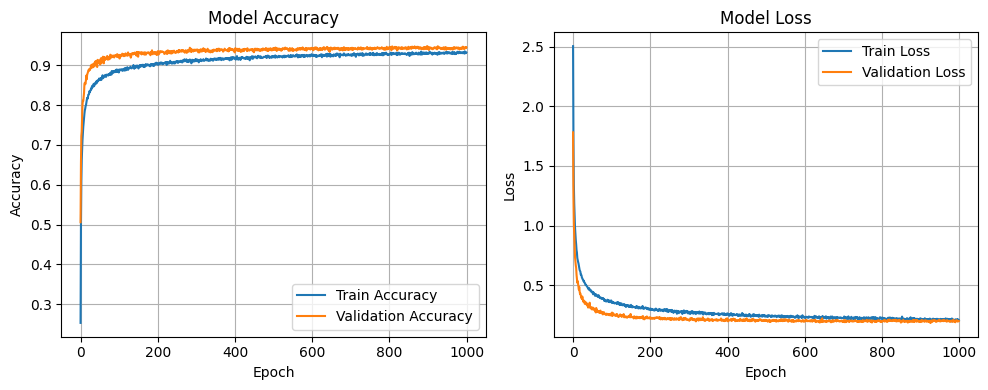

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# save model

In [15]:
import pickle

model.save(f"{model_name}.keras")
with open(f"{model_name}_label.pkl", "wb") as f:
    pickle.dump(le, f)

In [16]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the .tflite file
with open(f"{model_name}.tflite", "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /var/folders/jr/p2wykk054vn53_ltf2kxs8s80000gn/T/tmpvpnp1v_9/assets


INFO:tensorflow:Assets written to: /var/folders/jr/p2wykk054vn53_ltf2kxs8s80000gn/T/tmpvpnp1v_9/assets


Saved artifact at '/var/folders/jr/p2wykk054vn53_ltf2kxs8s80000gn/T/tmpvpnp1v_9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 126), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  6311294928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6311296848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6311296272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13784825936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13784826128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13784827472: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1760596056.954787 1027334 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1760596056.954797 1027334 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
I0000 00:00:1760596056.957118 1027334 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
